This project involves building a recommendation system based on two models

1. User features similarity (i.e if a user has a similar features like skin type, tone, eye color, hair color with another user, then probably th ey might enjoy same products)
2. Content-based recommendations (cosine similarity between the chemical compositions of the products)

Let's first start my importing all neccesary libraries

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnarDataSource, HoverTool, Select, Paragraph, TextInput
from bokeh.layouts import column, row
from ipywidgets import interact

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from matplotlib import cm

import markovify
import string

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes  import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings; warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/ama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
data = pd.read_csv('../Datasets/skindataall.csv', index_col=[0])

In [9]:
data.head(5)

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


<Axes: xlabel='Skin_Tone'>

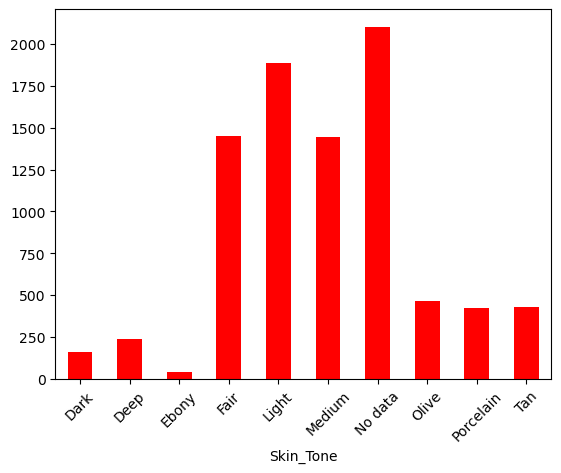

In [10]:
skintone_stats = data.groupby('Skin_Tone')['Username'].count()
skintone_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Skin_Type'>

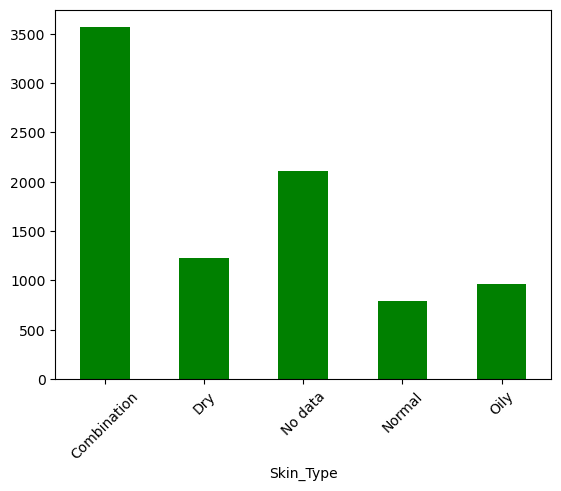

In [11]:
skintone_stats = data.groupby('Skin_Type')['Username'].count()
skintone_stats.plot.bar(color='green', rot=45)

<Axes: xlabel='Eye_Color'>

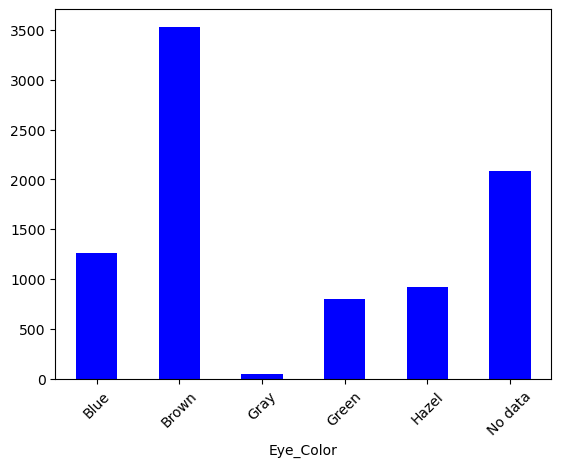

In [12]:
eyecolor_stats = data.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color='blue', rot=45)

<Axes: xlabel='Hair_Color'>

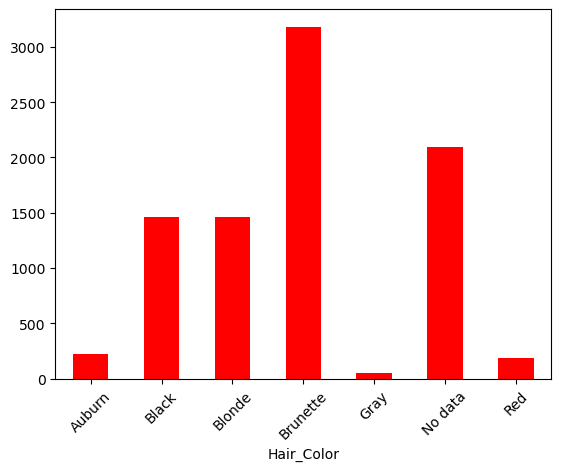

In [13]:
haircolor_stats = data.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Rating_Stars'>

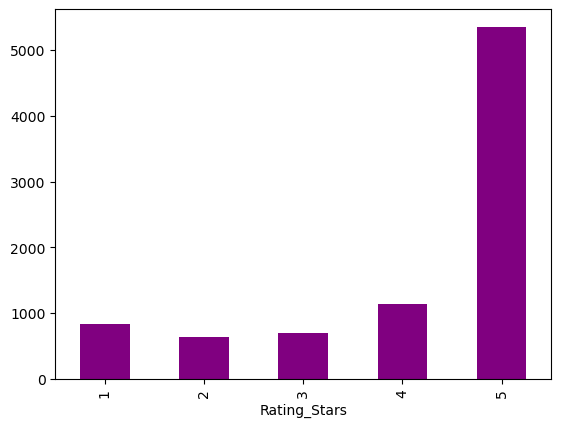

In [14]:
rating_stats = data.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color='purple')

From the graph above the ratings are unevenly distributed. We observe that the 5-star is more dorminant and with the 1 - 4 star ratings having a low frequency count. 

### Markov Chain neural net for langauge generator

In [15]:
import markovify
import string

In [16]:
def no_punct(string):
    no_punct_string = re.sub(r'[^\w\s]', '', string)
    return no_punct_string

In [17]:
data['Review'] = data.apply(lambda row: no_punct(row['Review']), axis=1)

In [18]:
text_model = markovify.NewlineText(data.Review, state_size=2)

In [19]:
for i in range(3):
    print(text_model.make_sentence())

Very gentle on your face Also I consider it my skin Feels good after two coats Does oxidize though so its worth the extremely high price tag it should be using this as a perfect base to to use I got this in a day and the pimple will be splurging on this product to help prevent any issues However I have sensitive acne prone and this is great for travel I have acne I had concerns that it was discontinued because it was it wasnt on stock I love this moisturizer for dry skin which is perfect to take off a lot I used it almost every single day for the amount of hydration Moisturizing but not all of my skin Finallymy skin is noticeably softer but Im very pleased with this bad I dont have sensitive skin and this toner It makes me look cakey at all Really Recommend
This winter my face always feels so soft and smooth The scent is light and moisturizing while wiping away the daily beat Its amazingly cleansing and toning I wake up in just one week before my skincare to family and my skin If you r

### NLP: wordclouds and classification

In [20]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [21]:
negative_data = data[data.Rating_Stars <= 4]
positive_data = data[data.Rating_Stars > 4]
negative = " ".join(review for review in negative_data.Review)
positive = " ".join(review for review in positive_data.Review)

In [22]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [23]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(data)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

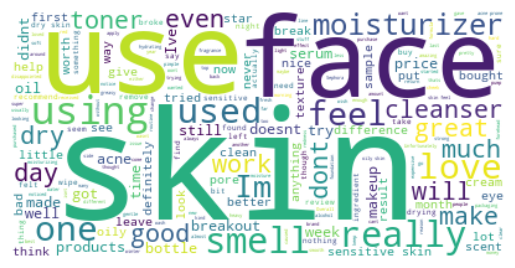

In [24]:
generate_wordcloud(negative)

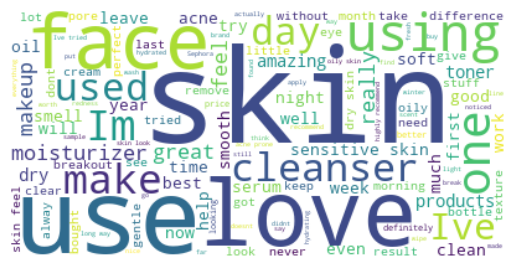

In [25]:
generate_wordcloud(positive)

Looking at wordcloud of negative reviews, you can see that a lot of people have a negative smell, complain about their face. 

We would proceed the ingredients of skincare products. Knowing very little on chemistry, let's proceed to distinguish between categories, such as serum

In [26]:
moist_data = data[data.Category == 'Moisturizer']
cleanse_data = data[data.Category == 'Cleanser']
mask_data = data[data.Category == 'Face Mask']
treat_data = data[data.Category == 'Treatment']

In [27]:
moist = ' '.join(ing for ing in moist_data.Ingredients)
cleanse = ' '.join(ing for ing in cleanse_data.Ingredients)
mask = ' '.join(ing for ing in mask_data.Ingredients)
treat = ' '.join(ing for ing in treat_data.Ingredients)

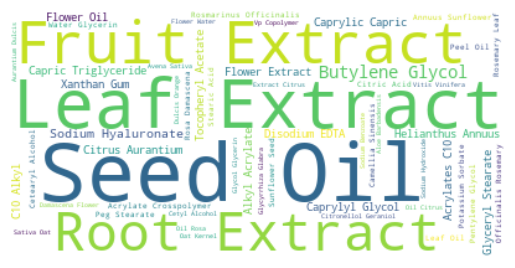

In [28]:
generate_wordcloud(moist)

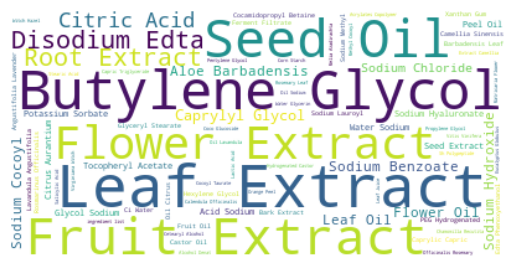

In [29]:
generate_wordcloud(cleanse)

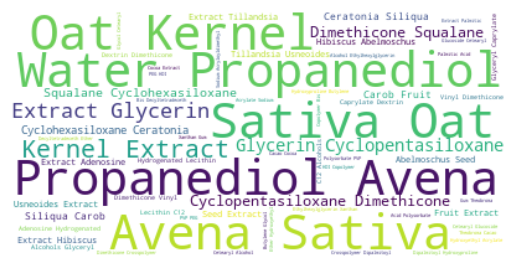

In [30]:
generate_wordcloud(mask)

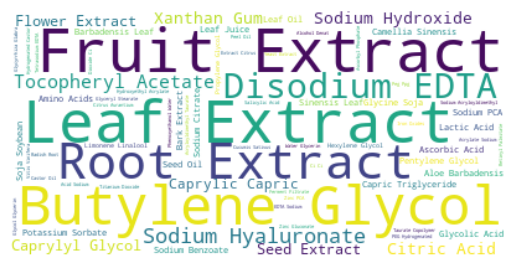

In [31]:
generate_wordcloud(treat)

We would proceed to build classification model to distinguish the products.

In [32]:
X = data.Ingredients
y = data.Category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

#### Naive Bayes

In [34]:
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### Logistic Regression

In [35]:
logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])

logreg.fit(X_train, y_train)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### SVG with SGD

In [36]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



### Latent Dirichlet Allocation

Now that w ehave different skincare categories would be distinguishable, we would proceed to do unsupervised clusstgering to figure out how the ingredients would group naturally.

In [43]:
from __future__ import print_function
import pyLDAvis
#import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [44]:
ing_raw = data.Ingredients

In [45]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(ing_raw)

In [46]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(ing_raw)

In [47]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [ ]:
pyLDAvis.sk

### Quality and effectiveness check

The ratings of a product are highly determined by the usefulness of a product in solving a customer problems. Thus the ingredients effectiveness would thus influence the rating of a product not it's packaging. Thus we would proceed to determine how a product's ingredients to determine its ratings

In [49]:
X1 = data.Ingredients
y1 = data.Good_Stuff
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state= 42)

In [50]:
cat =['1', '0']

#### Naive Bayes

In [51]:
nb = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ])

nb.fit(X_train1, y_train1)

y_pred1 = nb.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



#### Logistic Regression

In [55]:
logreg = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                    ])
                   
logreg.fit(X_train1, y_train1)
                   
print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



#### SVG with SGD

In [57]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train1, y_train1)

y_pred1 = sgd.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.6116504854368932
              precision    recall  f1-score   support

           1       0.61      0.05      0.09       856
           0       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163

